In [3]:
import numpy as np
from scipy import fftpack
import tensorly as tl
import time
from tensorly.decomposition import tucker
import tensorsketch
from tensorsketch import util
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle 
import simulation
plt.style.use('seaborn-paper')
%matplotlib inline 

In [4]:
def sim_name(gen_type,r,noise_level,dim): 
    """
    Obtain the file name to use for a given simulation setting
    """
    if noise_level == 0: 
        noise = "no"
    else: 
        noise = str(int(np.log10(noise_level)))
    return "data/typ"+gen_type+"_r"+str(r)+"_noise"+noise+"_dim"+str(dim)

In [5]:
def run_nssim(gen_type,r,noise_level, ns = np.arange(100,101,100), dim = 3, sim_runs = 1,random_seed = 1): 
    """
    Simulate multiple datasets with different n for multiple runs. For each run, perform the HOOI, 
    two pass sketching, and one pass sketching 
    
    :param gen_type: Type of random matrix used in sketching, including 'u' uniform, 'g' gaussian, 'sp'
        sparse radamacer. 
    :param r: tucker rank of the simulated tensor 
    :param noise_level: noise level. It inverse equals to the signal-to-noise ratio.  
    :param ns: array of different n, the side length of the square tensor 
    :param dim: the dimension of the square tensor 
    :param sim_runs: num of simulated runs in each setting 
    :param random_seed: random seed for generating the random matrix  
    """
    sim_list = []
    for id, n in enumerate(ns): 
        if gen_type in ['id','lk']: 
            ks =np.arange(r, int(n/2),int(n/20)) 
        elif gen_type in ['spd','fpd']: 
            ks = np.arange(r,int(n/5),int(n/50))
        else: 
            ks = np.arange(r,int(n/10),int(n/100))
        hooi_rerr = np.zeros((sim_runs, len(ks)))
        two_pass_rerr = np.zeros((sim_runs,len(ks)))
        one_pass_rerr = np.zeros((sim_runs,len(ks)))
        for i in range(sim_runs): 
            for idx, k in enumerate(ks): 
                simu = simulation.Simulation(n, r, k, 2*k+1, dim, SketchTen.util.RandomInfoBucket(random_seed), gen_type, noise_level)
                rerr_hooi, rerr_twopass, rerr_onepass = simu.run_sim()
                hooi_rerr[i,idx] = rerr_hooi
                two_pass_rerr[i,idx] = rerr_twopass
                one_pass_rerr[i,idx] = rerr_onepass
        sim_list.append([two_pass_rerr,one_pass_rerr,hooi_rerr])
    pickle.dump( sim_list, open(sim_name(gen_type,r,noise_level,dim) +".pickle", "wb" ) )
    return sim_list

In [6]:
def plot_nssim(gen_type,r,noise_level,name,n, ns = [200,400,600], dim = 3, sim_runs = 1,random_seed = 1,fontsize = 18): 
    '''
    Plot the simulation results given in run_nssim
    '''
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)
    sim_list = pickle.load( open( sim_name(gen_type,r,noise_level,dim)+".pickle", "rb" ) ) 
    plot_id = ns.index(n)
    if gen_type in ['id','lk']: 
        ks =np.arange(r, int(n/2),int(n/20)) 
    elif gen_type in ['spd','fpd']: 
        ks = np.arange(r,int(n/5),int(n/50))
    else: 
        ks = np.arange(r,int(n/10),int(n/100))
    plt.figure(figsize=(6,5))
    plt.plot(ks/n,np.mean(sim_list[plot_id][0],0), label = 'Two Pass',linestyle = '--',marker = 'X')
    plt.plot(ks/n,np.mean(sim_list[plot_id][1],0), label = 'One Pass', marker = 's',markeredgewidth=1,markeredgecolor='orange', markerfacecolor='None') 
    plt.plot(ks/n,np.mean(sim_list[plot_id][2],0), label = 'HOOI', linestyle = ':', marker = 'o', markeredgewidth=1,markeredgecolor='g', markerfacecolor='None') 
    plt.title("I = %s"%(n))
    plt.legend(loc = 'best')
    plt.xlabel('Compression Factor: $\delta_1$ = k/I')
    plt.ylabel('Relative Error')
    plt.yscale('log')
    plt.minorticks_off()
    alldata = np.concatenate((np.mean(sim_list[plot_id][0],0),np.mean(sim_list[plot_id][1],0),np.mean(sim_list[plot_id][2],0)))
    ymin = min(alldata)
    ymax = max(alldata)  
    def round_to_n(x,n): 
        return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
    ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
    plt.yticks(ticks)
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e')) 
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.savefig('plots/'+name)
    plt.show()

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

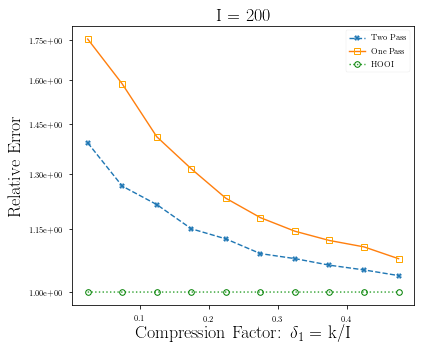

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


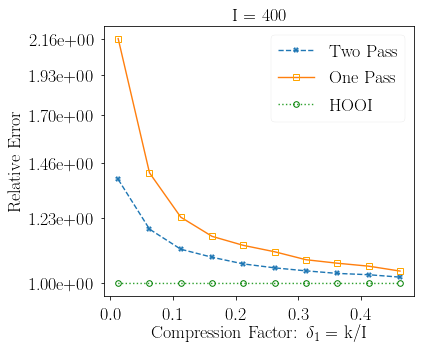

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


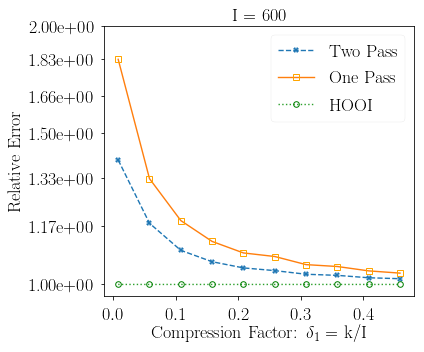

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


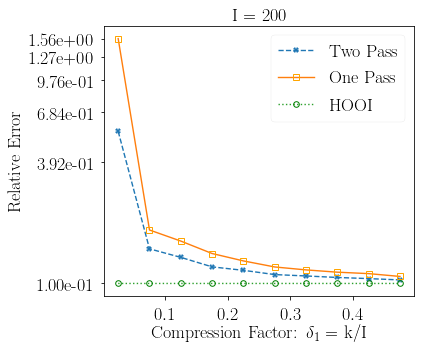

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


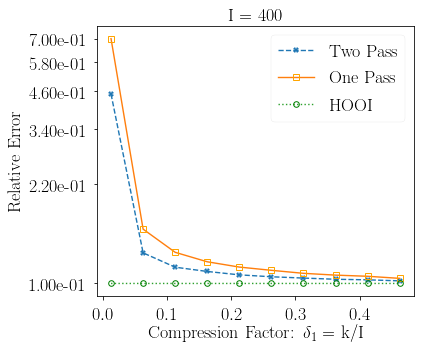

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


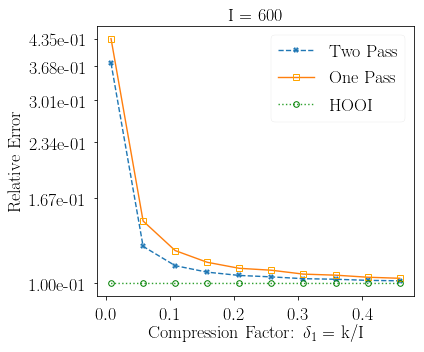

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


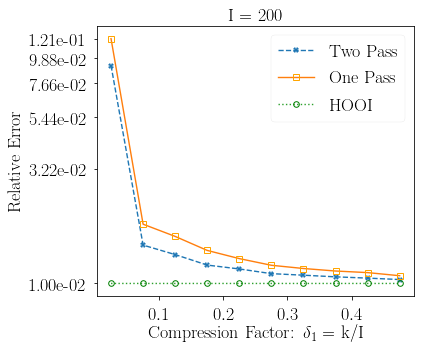

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


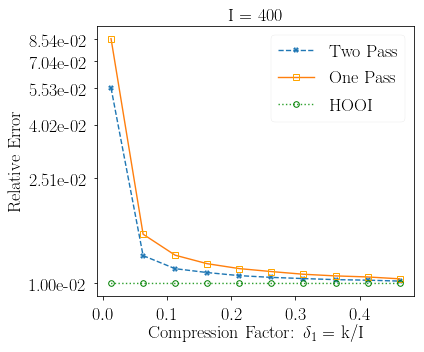

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


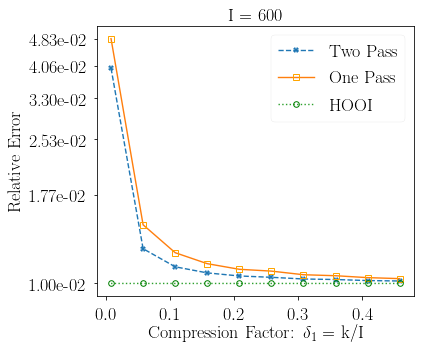

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


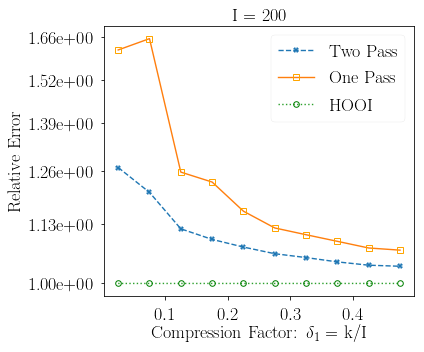

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


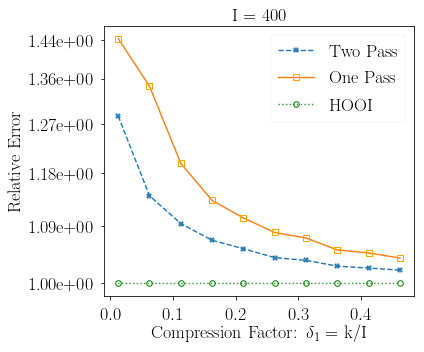

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


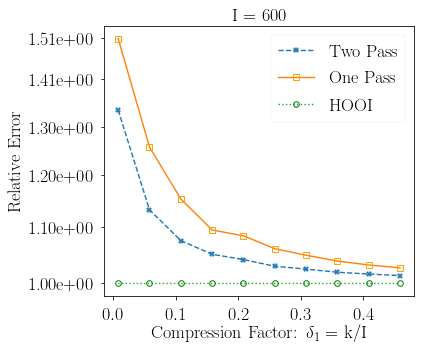

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


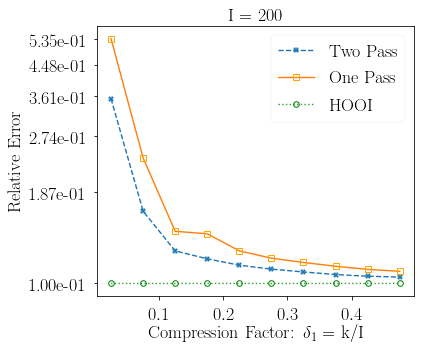

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


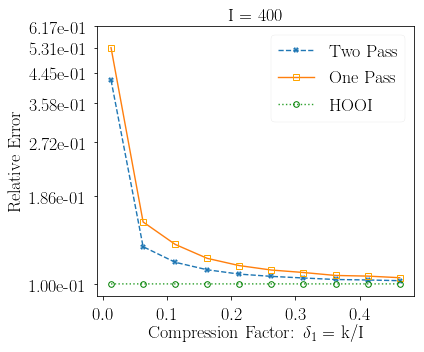

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


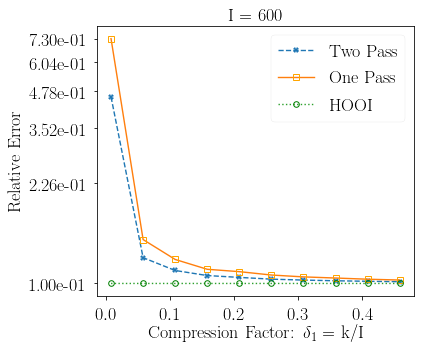

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


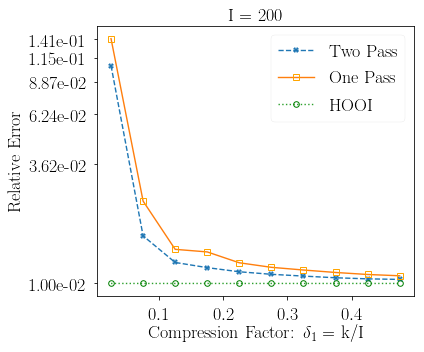

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


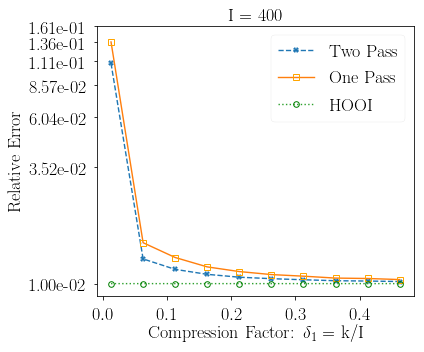

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


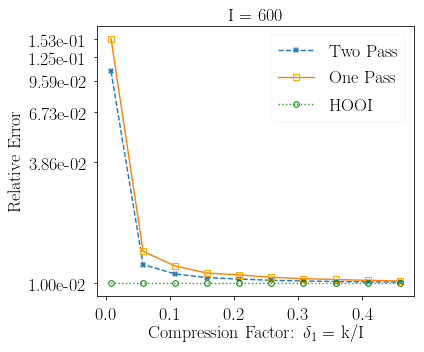

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


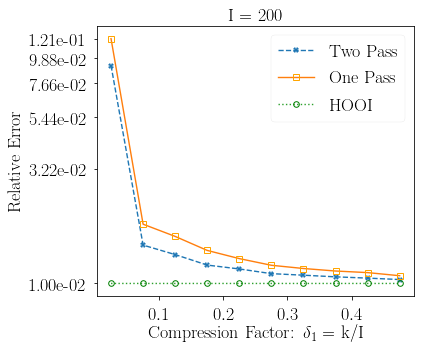

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


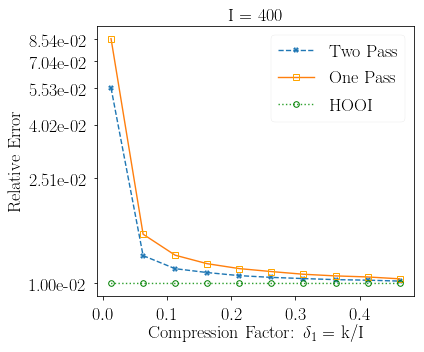

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


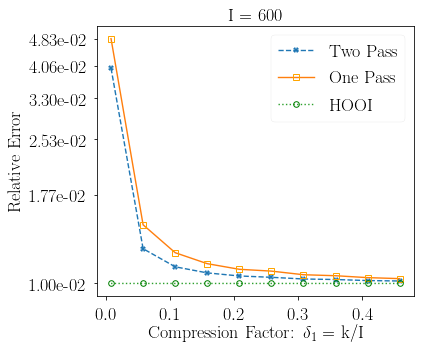

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


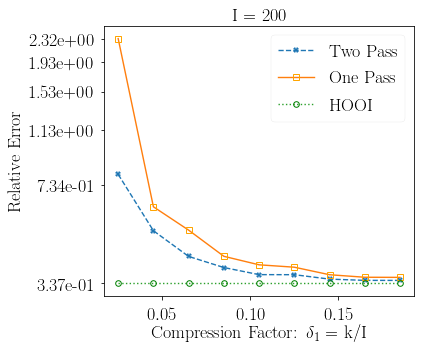

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


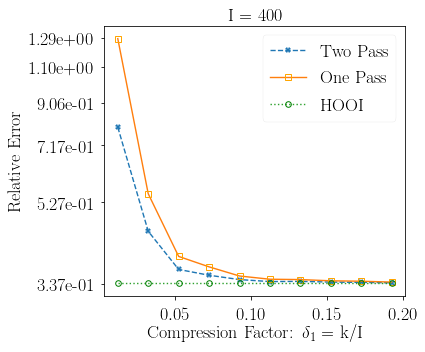

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


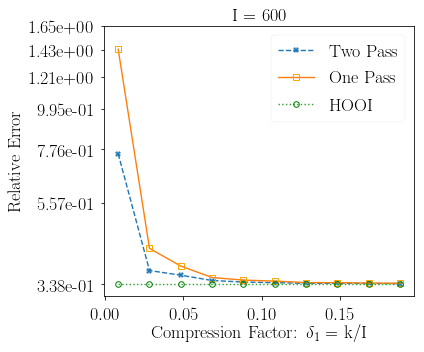

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


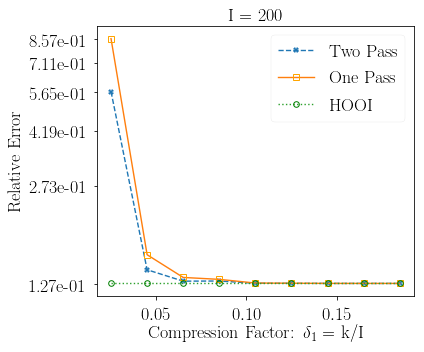

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


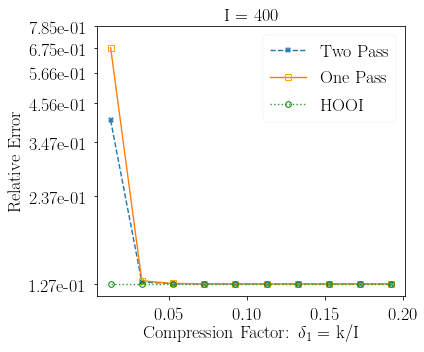

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


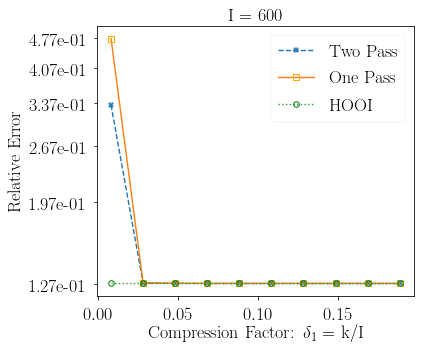

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


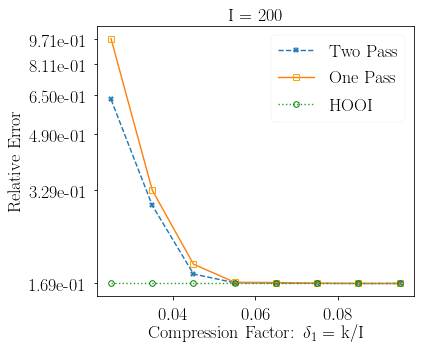

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


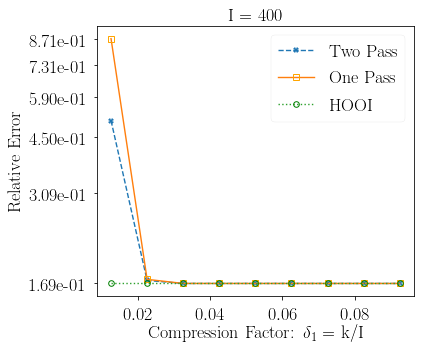

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


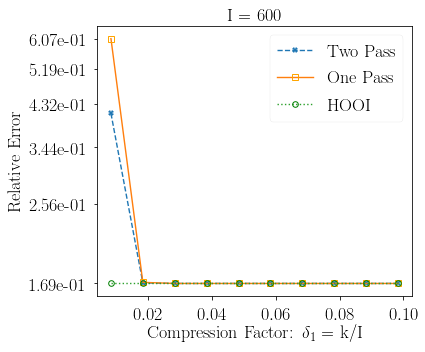

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


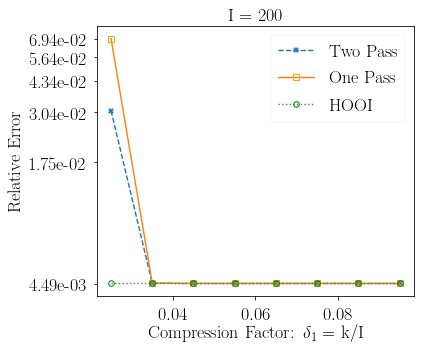

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


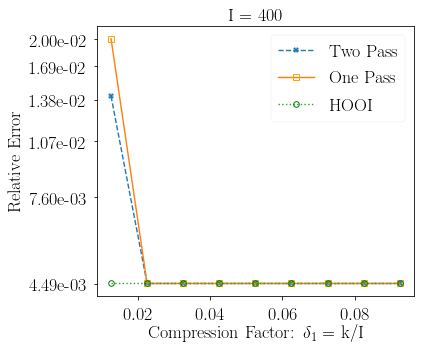

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


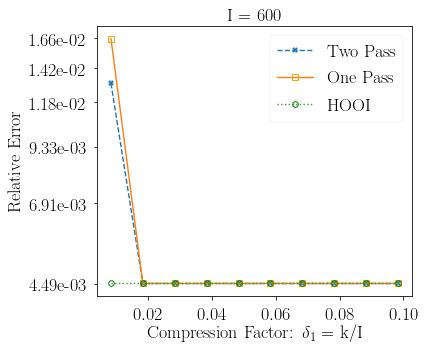

In [7]:
plot_nssim('id',5,1,"id_hnoise_n200.pdf",200)
plot_nssim('id',5,1,"id_hnoise_n400.pdf",400)
plot_nssim('id',5,1,"id_hnoise_n600.pdf",600)
plot_nssim('id',5,0.1,"id_mnoise_n200.pdf",200)
plot_nssim('id',5,0.1,"id_mnoise_n400.pdf",400)
plot_nssim('id',5,0.1,"id_mnoise_n600.pdf",600)
plot_nssim('id',5,0.01,"id_lnoise_n200.pdf",200)
plot_nssim('id',5,0.01,"id_lnoise_n400.pdf",400)
plot_nssim('id',5,0.01,"id_lnoise_n600.pdf",600)
plot_nssim('lk',5,1,"lk_hnoise_n200.pdf",200)
plot_nssim('lk',5,1,"lk_hnoise_n400.pdf",400)
plot_nssim('lk',5,1,"lk_hnoise_n600.pdf",600)
plot_nssim('lk',5,0.1,"lk_mnoise_n200.pdf",200)
plot_nssim('lk',5,0.1,"lk_mnoise_n400.pdf",400)
plot_nssim('lk',5,0.1,"lk_mnoise_n600.pdf",600)
plot_nssim('lk',5,0.01,"lk_lnoise_n200.pdf",200)
plot_nssim('lk',5,0.01,"lk_lnoise_n400.pdf",400)
plot_nssim('lk',5,0.01,"lk_lnoise_n600.pdf",600)
plot_nssim('id',5,0.01,"id_rk1_n200.pdf",200)
plot_nssim('id',5,0.01,"id_rk1_n400.pdf",400)
plot_nssim('id',5,0.01,"id_rk1_n600.pdf",600)
plot_nssim('spd',5,0.01,"spd_n200.pdf",200)
plot_nssim('spd',5,0.01,"spd_n400.pdf",400)
plot_nssim('spd',5,0.01,"spd_n600.pdf",600)
plot_nssim('fpd',5,0.01,"fpd_n200.pdf",200)
plot_nssim('fpd',5,0.01,"fpd_n400.pdf",400)
plot_nssim('fpd',5,0.01,"fpd_n600.pdf",600)
plot_nssim('sed',5,0.01,"sed_n200.pdf",200)
plot_nssim('sed',5,0.01,"sed_n400.pdf",400)
plot_nssim('sed',5,0.01,"sed_n600.pdf",600)
plot_nssim('fed',5,0.01,"fed_n200.pdf",200)
plot_nssim('fed',5,0.01,"fed_n400.pdf",400)
plot_nssim('fed',5,0.01,"fed_n600.pdf",600)

In [12]:
def plot_nssimlog(gen_type,r,noise_level,name,n, ns = [200,400,600], dim = 3, sim_runs = 1,random_seed = 1,fontsize = 18): 
    '''
    Plot the simulation results from run_nssim in the log scale. The plotted error is log(err(one or two pass)) - log(err(hooi)) 
    '''
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)
    sim_list = pickle.load( open( sim_name(gen_type,r,noise_level,dim)+".pickle", "rb" ) ) 
    plot_id = ns.index(n)
    if gen_type in ['id','lk']: 
        ks =np.arange(r, int(n/2),int(n/20)) 
    elif gen_type in ['spd','fpd']: 
        ks = np.arange(r,int(n/5),int(n/50))
    else: 
        ks = np.arange(r,int(n/10),int(n/100))
    plt.figure(figsize=(6,5))
    two_pass_result = np.mean(sim_list[plot_id][0],0)  
    one_pass_result = np.mean(sim_list[plot_id][1],0)
    hosvd_result = np.mean(sim_list[plot_id][2],0) 
    two_pass_logratio = [np.log(two_pass_result[i]/hosvd_result[i]) for i in range(len(hosvd_result))]
    one_pass_logratio = [np.log(one_pass_result[i]/hosvd_result[i]) for i in range(len(hosvd_result))]
    plt.plot(ks/n, two_pass_logratio, label = 'Two Pass',linestyle = '--',marker = 'X')
    plt.plot(ks/n, one_pass_logratio, label = 'One Pass', marker = 's',markeredgewidth=1,markeredgecolor='orange', markerfacecolor='None') 
    plt.title("I = %s"%(n))
    #plt.title("$\gamma$ = %s"%(noise_level))
    plt.legend(loc = 'best')
    plt.xlabel('Compression Factor: $\delta_1$ = k/I')
    plt.ylabel('log(Relative Error)')
    plt.minorticks_off()
    alldata = np.concatenate([two_pass_logratio,one_pass_logratio])
    ymin = 0
    ymax = max(alldata)  
    def round_to_n(x,n): 
        if x == 0: 
            return 0
        else:
            return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
    ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
    plt.yticks(ticks)
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e')) 
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.savefig('plots/'+name)
    plt.show()

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

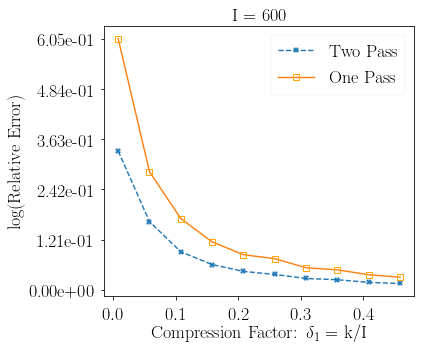

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

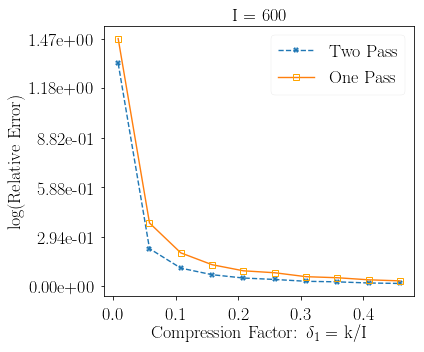

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

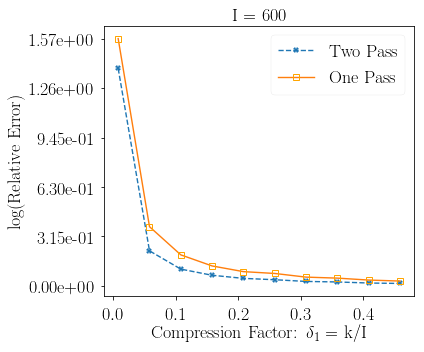

In [13]:
plot_nssimlog('id',5,1,"id_hnoise_n600log_paper.pdf",600)
plot_nssimlog('id',5,0.1,"id_mnoise_n600log_paper.pdf",600)
plot_nssimlog('id',5,0.01,"id_lnoise_n600log_paper.pdf",600)

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

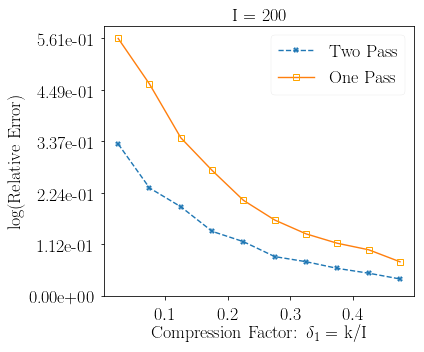

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

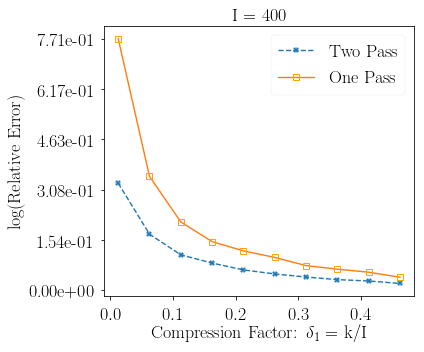

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


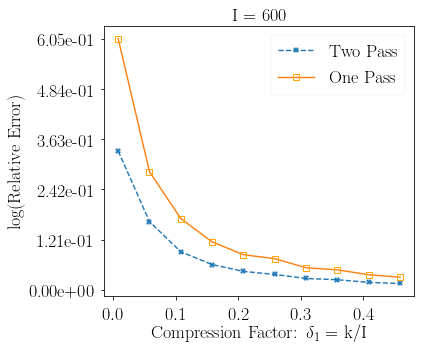

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

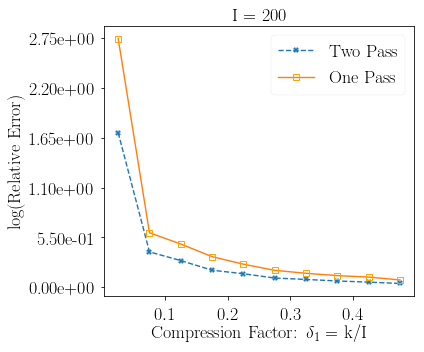

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

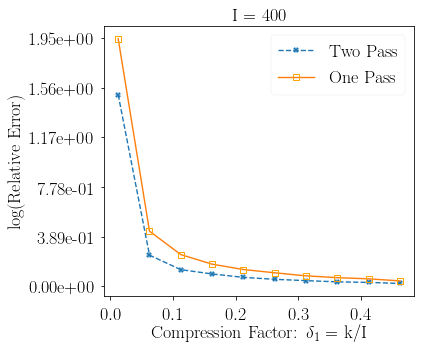

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


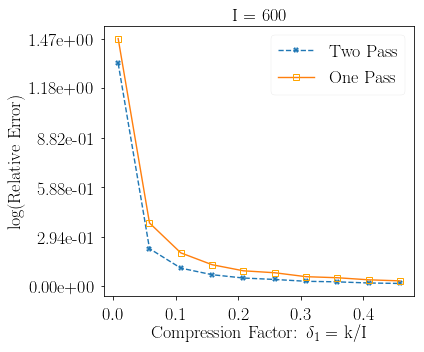

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

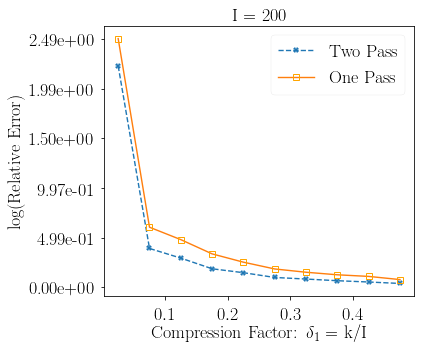

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

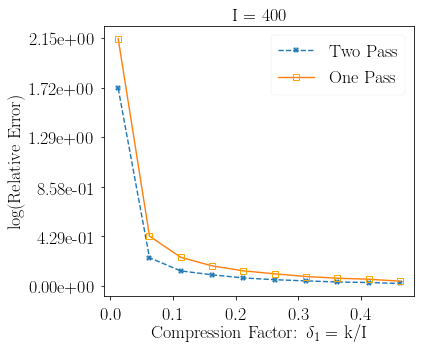

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


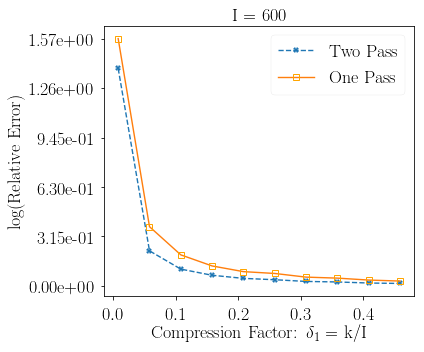

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

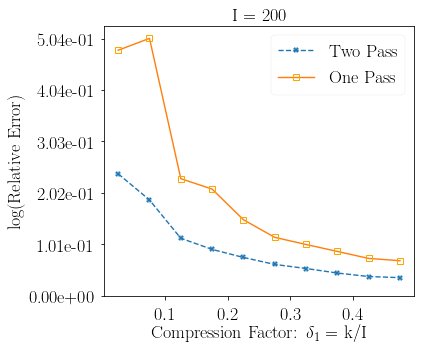

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

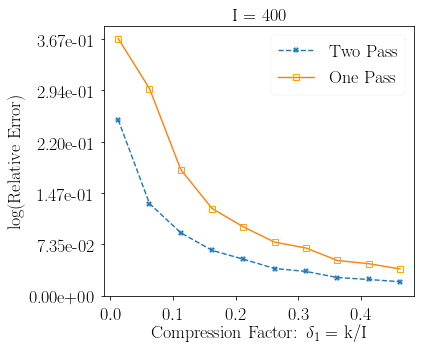

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

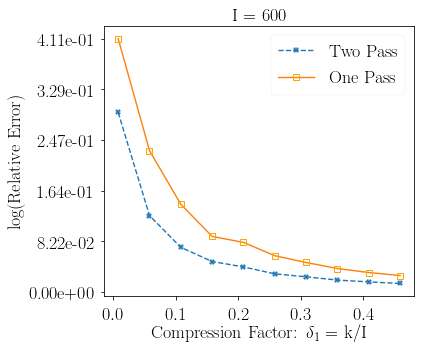

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

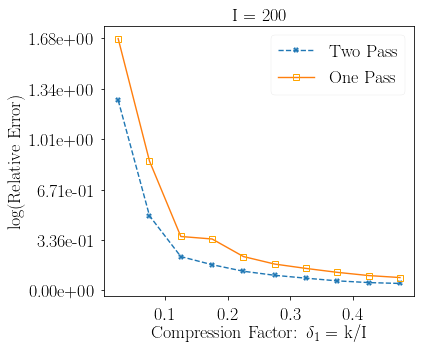

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

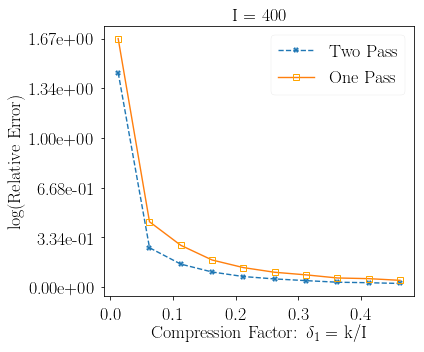

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

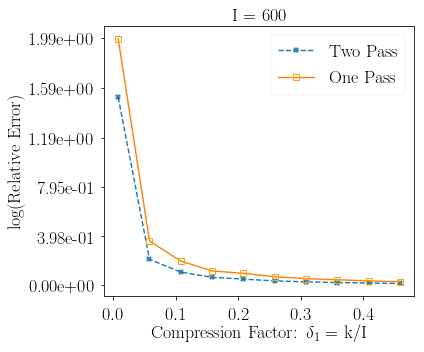

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

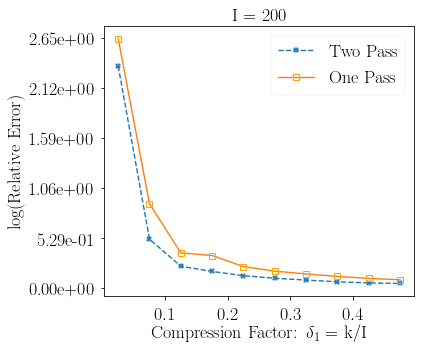

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

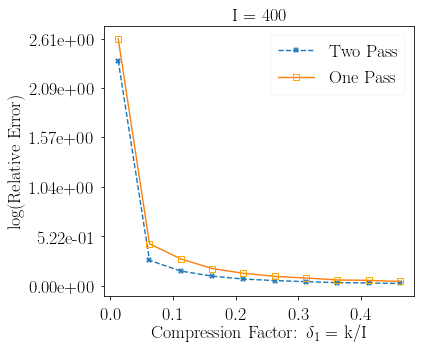

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

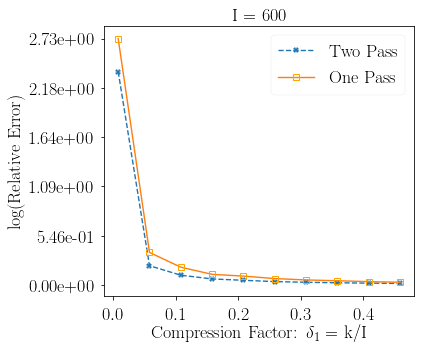

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


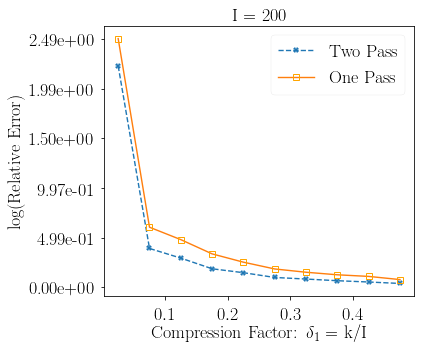

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


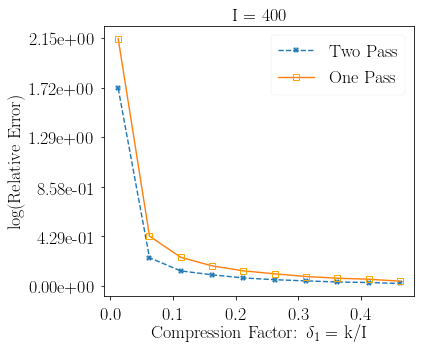

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


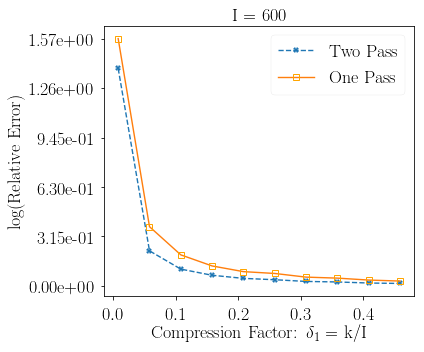

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

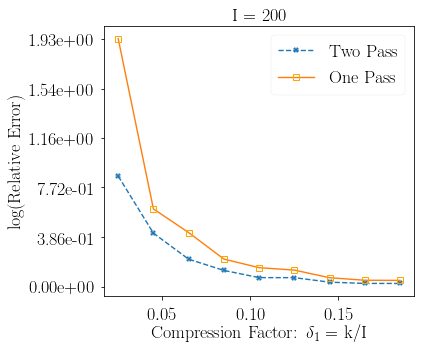

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

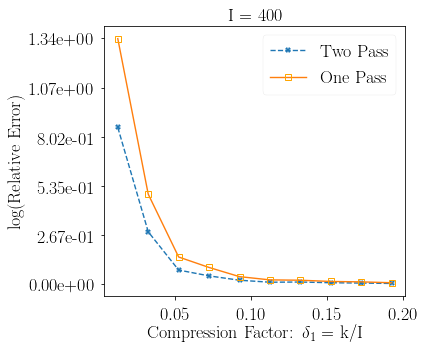

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

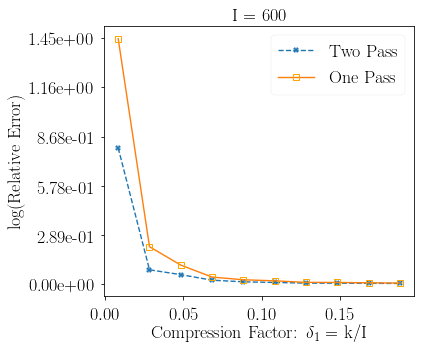

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

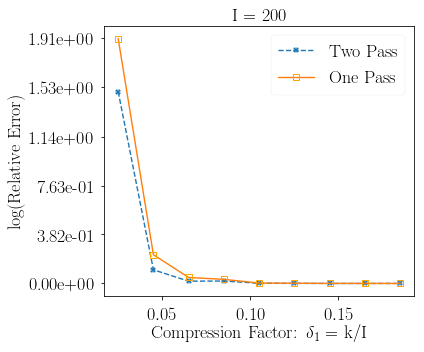

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


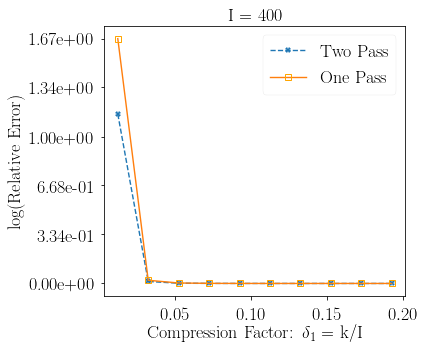

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

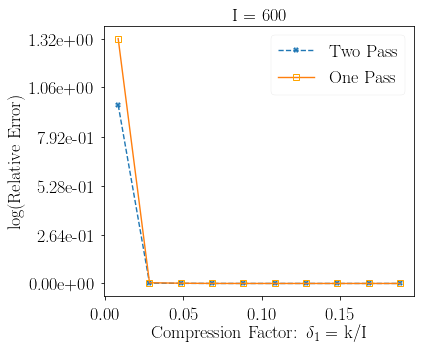

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

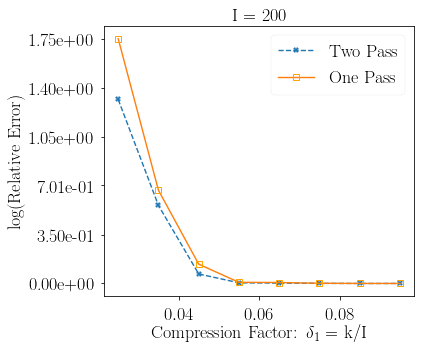

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

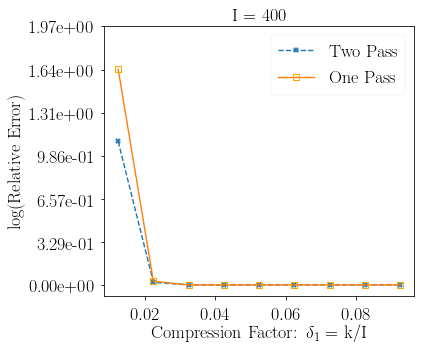

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

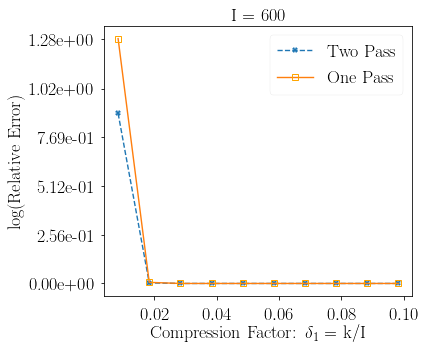

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

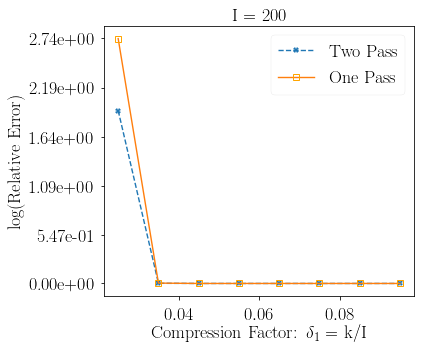

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

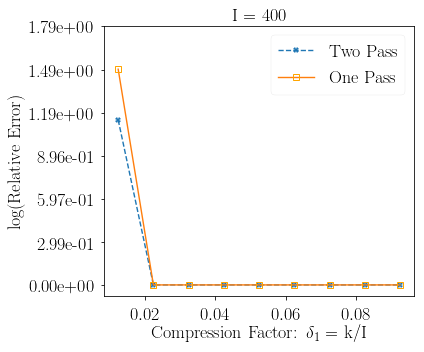

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

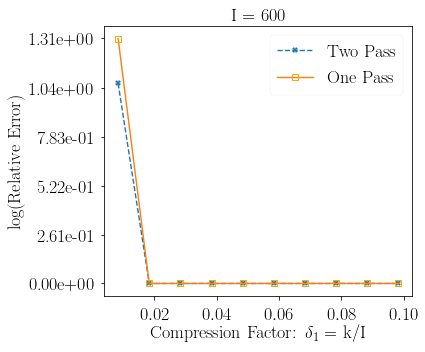

In [14]:
plot_nssimlog('id',5,1,"id_hnoise_n200log.pdf",200)
plot_nssimlog('id',5,1,"id_hnoise_n400log.pdf",400)
plot_nssimlog('id',5,1,"id_hnoise_n600log.pdf",600)
plot_nssimlog('id',5,0.1,"id_mnoise_n200log.pdf",200)
plot_nssimlog('id',5,0.1,"id_mnoise_n400log.pdf",400)
plot_nssimlog('id',5,0.1,"id_mnoise_n600log.pdf",600)
plot_nssimlog('id',5,0.01,"id_lnoise_n200log.pdf",200)
plot_nssimlog('id',5,0.01,"id_lnoise_n400log.pdf",400)
plot_nssimlog('id',5,0.01,"id_lnoise_n600log.pdf",600)
plot_nssimlog('lk',5,1,"lk_hnoise_n200log.pdf",200)
plot_nssimlog('lk',5,1,"lk_hnoise_n400log.pdf",400)
plot_nssimlog('lk',5,1,"lk_hnoise_n600log.pdf",600)
plot_nssimlog('lk',5,0.1,"lk_mnoise_n200log.pdf",200)
plot_nssimlog('lk',5,0.1,"lk_mnoise_n400log.pdf",400)
plot_nssimlog('lk',5,0.1,"lk_mnoise_n600log.pdf",600)
plot_nssimlog('lk',5,0.01,"lk_lnoise_n200log.pdf",200)
plot_nssimlog('lk',5,0.01,"lk_lnoise_n400log.pdf",400)
plot_nssimlog('lk',5,0.01,"lk_lnoise_n600log.pdf",600)
plot_nssimlog('id',5,0.01,"id_rk1_n200log.pdf",200)
plot_nssimlog('id',5,0.01,"id_rk1_n400log.pdf",400)
plot_nssimlog('id',5,0.01,"id_rk1_n600log.pdf",600)
plot_nssimlog('spd',5,0.01,"spd_n200log.pdf",200)
plot_nssimlog('spd',5,0.01,"spd_n400log.pdf",400)
plot_nssimlog('spd',5,0.01,"spd_n600log.pdf",600)
plot_nssimlog('fpd',5,0.01,"fpd_n200log.pdf",200)
plot_nssimlog('fpd',5,0.01,"fpd_n400log.pdf",400)
plot_nssimlog('fpd',5,0.01,"fpd_n600log.pdf",600)
plot_nssimlog('sed',5,0.01,"sed_n200log.pdf",200)
plot_nssimlog('sed',5,0.01,"sed_n400log.pdf",400)
plot_nssimlog('sed',5,0.01,"sed_n600log.pdf",600)
plot_nssimlog('fed',5,0.01,"fed_n200log.pdf",200)
plot_nssimlog('fed',5,0.01,"fed_n400log.pdf",400)
plot_nssimlog('fed',5,0.01,"fed_n600log.pdf",600)

In [ ]:
run_nssim('sed',5,0.01,np.arange(200,601,200)) 
run_nssim('fed',5,0.01,np.arange(200,601,200)) 
run_nssim('spd',5,0.01,np.arange(200,601,200)) 
run_nssim('fpd',5,0.01,np.arange(200,601,200)) 
run_nssim('id',5,0.01,np.arange(200,601,200)) 
run_nssim('id',5,0.1,np.arange(200,601,200)) 
run_nssim('id',5,1,np.arange(200,601,200)) 
run_nssim('id',1,0.01,np.arange(200,601,200)) 
run_nssim('lk',5,0.01,np.arange(200,601,200)) 
run_nssim('lk',5,0.1,np.arange(200,601,200)) 
run_nssim('lk',5,1,np.arange(200,601,200)) 

In [15]:
def run_nssim_fk(gen_type,r0,noise_level, n, dim = 3,random_seed = 1): 
    '''
    Simulate the dataset with fixed k and varying rank r, and perform HOOI, two-pass sketching, one-pass
    sketching for each setting. 
    '''
    X, X0 = tensorsketch.util.square_tensor_gen(n, r0, dim, typ=gen_type,\
         noise_level=noise_level, seed = random_seed)
    k = int(n*1/3)  
    s = 2*k+1
    rs = np.arange(int(r0/2),int(n/10),int(n/200))
    hooi_result = np.zeros(len(rs))
    two_pass_result = np.zeros(len(rs))
    one_pass_result = np.zeros(len(rs))
    for idx, r in enumerate(rs): 
        simu = simulation.Simulation(n, r, k, 2*k+1, dim, tensorsketch.util.RandomInfoBucket(random_seed), gen_type, noise_level)
        rerr_hooi, rerr_twopass, rerr_onepass = simu.run_sim()
        hooi_result[idx] = rerr_hooi
        two_pass_result[idx] = rerr_twopass
        one_pass_result[idx] = rerr_onepass
    sim_list = [two_pass_result,one_pass_result,hooi_result]
    pickle.dump( sim_list, open(sim_name(gen_type,r0,noise_level,dim) +"_n"+str(n)+"fk.pickle", "wb" ) )
    return sim_list

In [16]:
def plot_nssim_fk(gen_type,r0,noise_level, n, name, title, dim = 3,random_seed = 1,fontsize = 18): 
    sim_list = pickle.load(open(sim_name(gen_type,r0,noise_level,dim) +"_n"+str(n)+"fk.pickle","rb"))
    k = int(n*1/3)  
    s = 2*k+1
    rs = np.arange(int(r0/2),int(n/10),int(n/200))
    rratios = rs/n
    
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)    
    plt.figure(figsize=(6,5))
    two_pass_result = [np.log(sim_list[0][i]/sim_list[2][i]) for i in range(len(sim_list[2]))]
    one_pass_result = [np.log(sim_list[1][i]/sim_list[2][i]) for i in range(len(sim_list[2]))]
        
    plt.plot(rratios,two_pass_result, label = 'Two Pass',linestyle = '--',marker = 'X')
    plt.plot(rratios,one_pass_result, label = 'One Pass', marker = 's',markeredgewidth=1,markeredgecolor='orange', markerfacecolor='None') 
    plt.legend(loc = 'best')
    plt.title(title)
    plt.xlabel('Relative Rank: $rk/I$')
    plt.ylabel('log(Relative Error)')
    plt.minorticks_off()
    alldata = np.concatenate([one_pass_result,two_pass_result])
    ymin = min(alldata)
    ymax = max(alldata) 
    def round_to_n(x,n): 
        if x == 0: 
            return 0
        else: 
            return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
    ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
    plt.yticks(ticks)
    plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e')) 
    plt.axes().xaxis.set_major_locator(ticker.MaxNLocator(10))
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.axhline(0, color='black',linewidth = 1)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.savefig("plots/"+name+".pdf")
    plt.show()

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

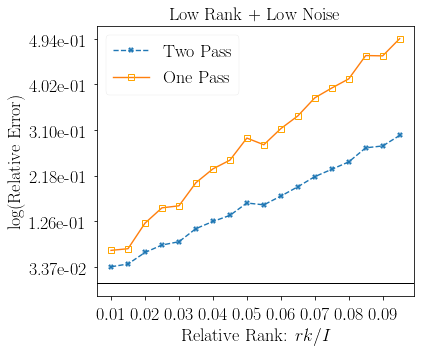

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

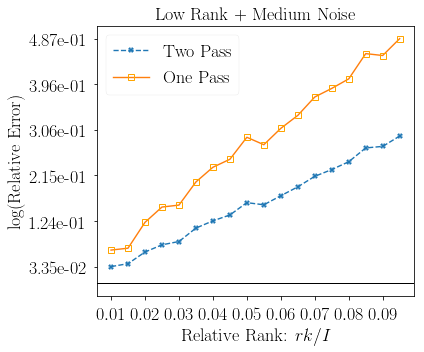

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

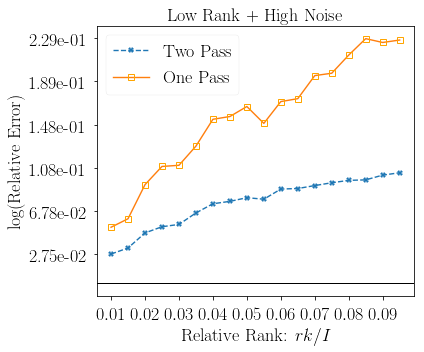

In [22]:
plot_nssim_fk('lk',5,0.01,200,'lk_lnoise_n200fk', "Low Rank + Low Noise")
plot_nssim_fk('lk',5,0.1,200,'lk_mnoise_n200fk', "Low Rank + Medium Noise")
plot_nssim_fk('lk',5,1,200,'lk_hnoise_n200fk', "Low Rank + High Noise ")

In [20]:
run_nssim_fk('spd',5,0.01,600)
run_nssim_fk('fpd',5,0.01,600)
run_nssim_fk('sed',5,0.01,600)

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

ArpackError: ARPACK error 3: No shifts could be applied during a cycle of the Implicitly restarted Arnoldi iteration. One possibility is to increase the size of NCV relative to NEV. 

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

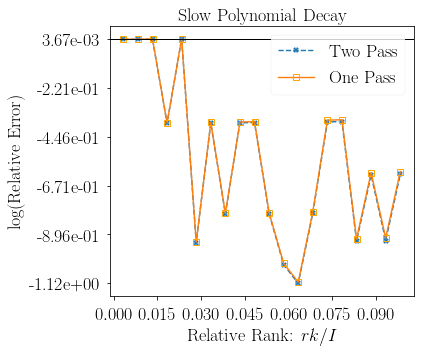

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

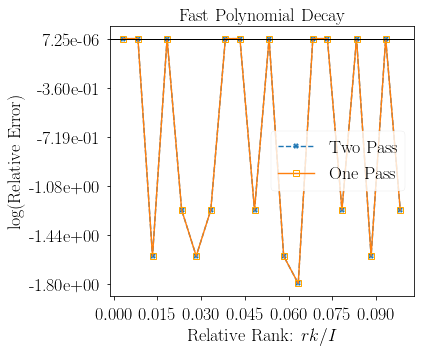

/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/apple/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserW

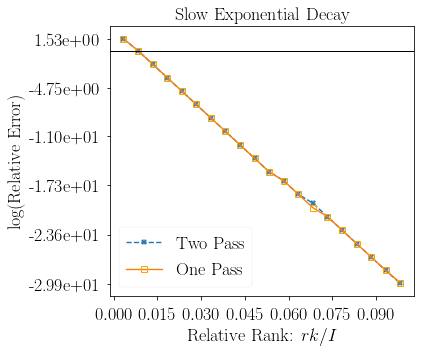

In [21]:
plot_nssim_fk('spd',5,0.01,600,'spd_n600fk','Slow Polynomial Decay')
plot_nssim_fk('fpd',5,0.01,600, 'fpd_n600fk','Fast Polynomial Decay')
plot_nssim_fk('sed',5,0.01,600, 'sed_n600fk','Slow Exponential Decay')